In [1]:
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
# bybitのAPIに接続
exchange = ccxt.bybit()

In [3]:
# 開始日時と終了日時を指定（ここでは例として2022年1月1日から2022年12月31日までを指定）
start_date = datetime(2024, 8, 28)
end_date = datetime(2024, 8, 29)
start_timestamp = int(start_date.timestamp() * 1000)
end_timestamp = int(end_date.timestamp() * 1000)

data = []

In [4]:
while start_timestamp < end_timestamp:
    try:
        new_data = exchange.fetch_ohlcv('ETHUSDT', timeframe='1m', since=start_timestamp, limit=1000)
        if new_data:
            start_timestamp = new_data[-1][0] + 1
            data += new_data
        else:
            break
    except Exception as e:
        print(f"An error occurred: {e}")
        break

# データをDataFrameに変換
df = pd.DataFrame(data, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

print(df.head())

            Timestamp     Open     High      Low    Close   Volume
0 2024-08-27 15:00:00  2584.93  2585.98  2583.10  2583.55  1882.36
1 2024-08-27 15:01:00  2583.55  2584.65  2581.65  2581.78  1282.10
2 2024-08-27 15:02:00  2581.78  2583.88  2580.64  2580.83  1459.04
3 2024-08-27 15:03:00  2580.83  2582.43  2578.52  2582.12  3126.21
4 2024-08-27 15:04:00  2582.12  2582.32  2580.00  2580.96  1014.71


In [5]:
df.set_index('Timestamp', inplace=True)

In [6]:
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

In [7]:
df['SMA1'] = df['Close'].rolling(42).mean()
df['SMA2'] = df['Close'].rolling(252).mean()

In [8]:
%matplotlib inline
from pylab import mpl, plt

/tmp/ipykernel_194/3500455968.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<AxesSubplot: title={'center': 'ETHUSDT | 42 & 252 minutes SMAs'}, xlabel='Timestamp'>

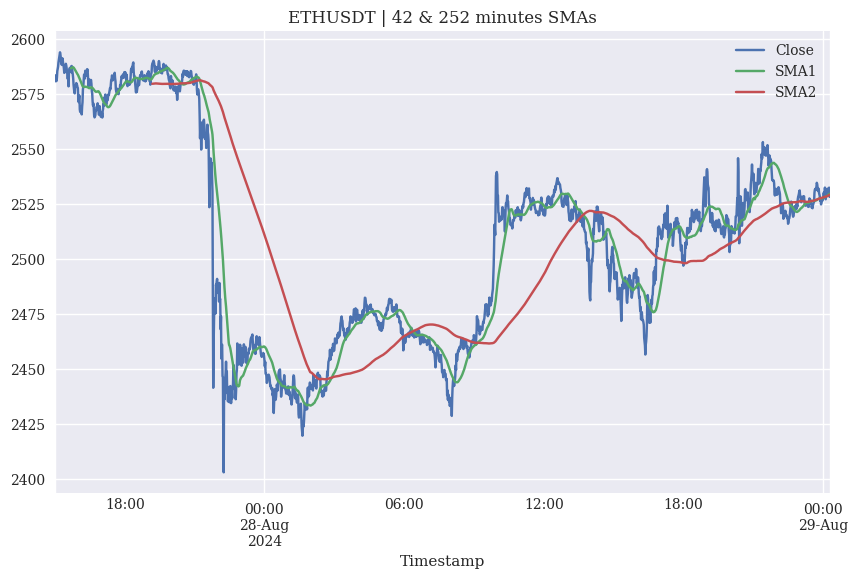

In [9]:
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
df.plot(title='ETHUSDT | 42 & 252 minutes SMAs', figsize=(10,6))

In [10]:
df['position'] = np.where(df['SMA1'] > df['SMA2'],1,-1)

In [11]:
df.dropna(inplace=True)

<AxesSubplot: title={'center': 'Market Positioning'}, xlabel='Timestamp'>

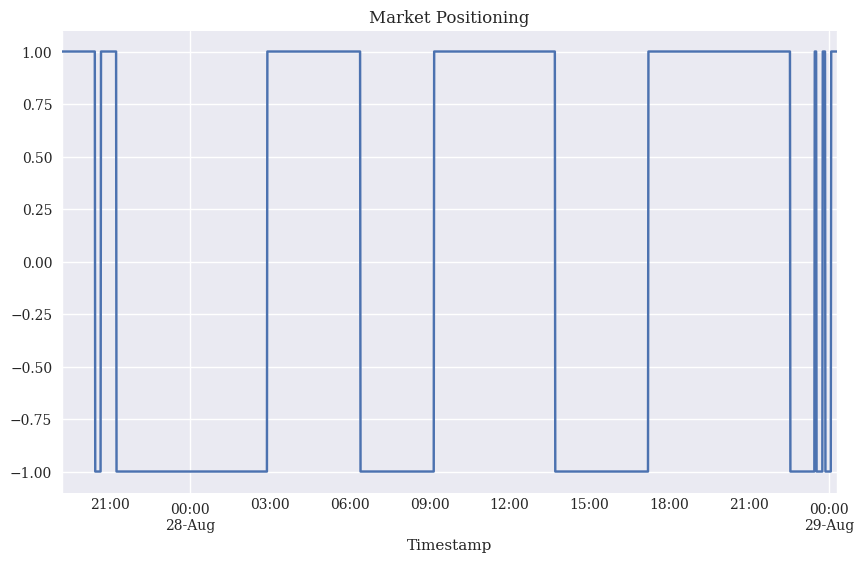

In [12]:
df['position'].plot(ylim=[-1.1,1.1],title='Market Positioning', figsize=(10,6))

In [13]:
df['returns'] = np.log(df['Close']/df['Close'].shift(1))

<AxesSubplot: >

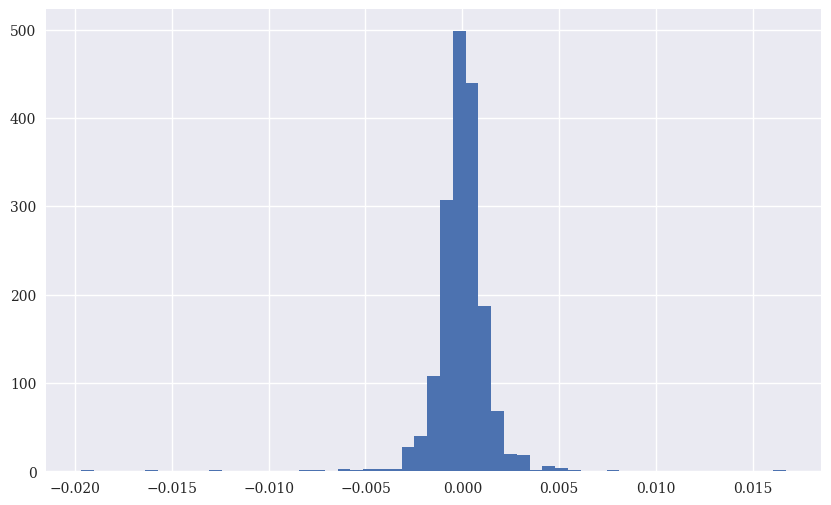

In [14]:
df['returns'].hist(bins=55, figsize=(10,6))

In [15]:
df['strategy'] = df['position'].shift(1) * df['returns']

In [16]:
df[['returns','strategy']].sum() 

returns    -0.023303
strategy    0.026324
dtype: float64

In [18]:
df[['returns','strategy']].sum().apply(np.exp)

returns     0.976967
strategy    1.026674
dtype: float64

<AxesSubplot: xlabel='Timestamp'>

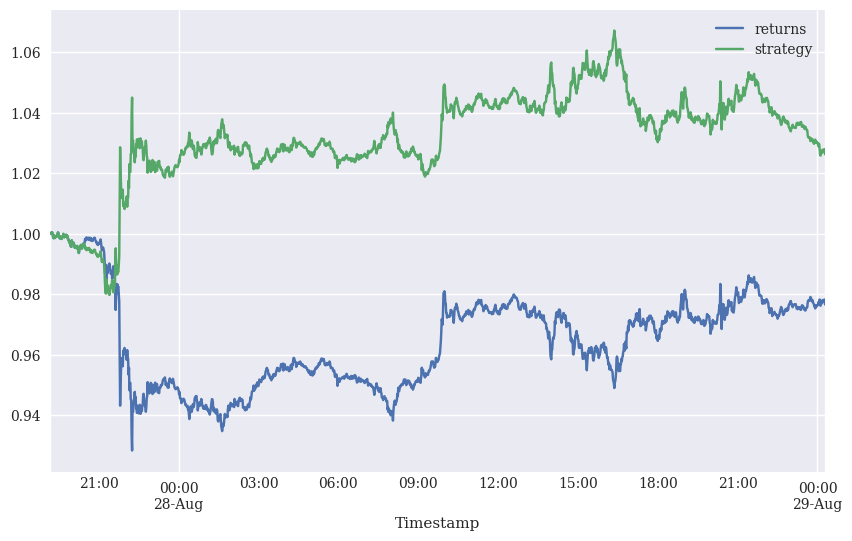

In [20]:
df[['returns','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))